In [1]:
from google.colab import drive 
drive.mount('/content/drive', force_remount=True)

MessageError: ignored

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
import random
import cv2
import os
import tensorflow as tf
from tqdm import tqdm

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

In [ ]:
good_frames = '/content/drive/MyDrive/idb/dataset/Sharp/xray'
blur_frames= '/content/drive/MyDrive/idb/gblur'

In [ ]:
clean_frames = []
for file in tqdm(sorted(os.listdir(good_frames))):
  if any(extension in file for extension in ['.jpg', 'jpeg', '.png']):
    image = tf.keras.preprocessing.image.load_img(good_frames + '/' + file, target_size=(224,224))
    image = tf.keras.preprocessing.image.img_to_array(image).astype('float32') / 255
    clean_frames.append(image)

clean_frames = np.array(clean_frames)
blurry_frames = []
for file in tqdm(sorted(os.listdir(blur_frames))):
  if any(extension in file for extension in ['.jpg', 'jpeg', '.png']):
    image = tf.keras.preprocessing.image.load_img(blur_frames + '/' + file, target_size=(224,224))
    image = tf.keras.preprocessing.image.img_to_array(image).astype('float32') / 255
    blurry_frames.append(image)

blurry_frames = np.array(blurry_frames)

100%|██████████| 400/400 [00:08<00:00, 46.80it/s]


In [ ]:
x = clean_frames;
y = blurry_frames;
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
import numpy as np
import cv2
import os
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Load sharp and blur images
sharp_images = []
blur_images = []

for file in os.listdir('/content/drive/MyDrive/idb/dataset/Sharp/xray'):
    img = cv2.imread(os.path.join('/content/drive/MyDrive/idb/dataset/Sharp/xray', file))
    img = cv2.resize(img, (224, 224))
    img = img/255.0
    sharp_images.append(img)
    
for file in os.listdir('/content/drive/MyDrive/idb/dataset/Blur'):
    img = cv2.imread(os.path.join('/content/drive/MyDrive/idb/dataset/Blur', file))
    img = cv2.resize(img, (224, 224))
    img = img/255.0
    blur_images.append(img)

sharp_images = np.array(sharp_images)
blur_images = np.array(blur_images)

# Split into train and validation sets
train_sharp, val_sharp, train_blur, val_blur = train_test_split(sharp_images, blur_images, test_size=0.2, random_state=42)




In [ ]:
inputs = Input(shape=(224, 224, 3))

conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
drop5 = Dropout(0.5)(conv5)

up6 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(drop5))
merge6 = concatenate([drop4, up6], axis=3)
conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

up7 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
merge7 = concatenate([conv3, up7], axis=3)
conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

up8 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
merge8 = concatenate([conv2, up8], axis=3)
conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

up9 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
merge9 = concatenate([conv1, up9], axis=3)
conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

conv10 = Conv2D(3, 1, activation='sigmoid')(conv9)


model1 = Model(inputs=inputs, outputs=conv10)
h=1
model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_23 (Conv2D)             (None, 224, 224, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_24 (Conv2D)             (None, 224, 224, 64  36928       ['conv2d_23[0][0]']              
                                )                                                           

In [ ]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

def train(model, train_sharp, train_blur, val_sharp, val_blur, batch_size, epochs):
    opt = Adam(lr=1e-4)
    model.compile(loss='mse', optimizer=opt, metrics=['accuracy'])
    checkpoint = ModelCheckpoint('model1.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    callbacks_list = [checkpoint]
    model.fit(train_blur, train_sharp, batch_size=batch_size, epochs=epochs, validation_data=(val_blur, val_sharp), callbacks=callbacks_list)
    model.save("/content/drive/MyDrive/idb/saved_model/Unet/unetkeras1.h5")

def validate(model, val_sharp, val_blur):
    opt = Adam(lr=1e-4)
    model.compile(loss='mse', optimizer=opt, metrics=['accuracy'])
    model.load_weights('model1.h5')
    loss, acc = model1.evaluate(val_blur, val_sharp)
    print('Validation Loss:', loss)
    print('Validation Accuracy:', acc)

    pred_sharp = model.predict(val_blur)
    psnr = peak_signal_noise_ratio(val_sharp, pred_sharp)
    ssim = structural_similarity(val_sharp, pred_sharp, multichannel=True)
    print('PSNR:', psnr)
    print('SSIM:', ssim)
    return loss, acc

In [ ]:
train(model1, train_sharp, train_blur, val_sharp, val_blur, batch_size=32, epochs=15)
validate(model1, val_sharp, val_blur)

Epoch 1/15
10/10 [==============================] - ETA: 0s - loss: 0.0458 - accuracy: 0.1560
Epoch 1: val_loss improved from inf to 0.03000, saving model to model1.h5
10/10 [==============================] - 27s 2s/step - loss: 0.0458 - accuracy: 0.1560 - val_loss: 0.0300 - val_accuracy: 0.0108
Epoch 2/15
10/10 [==============================] - ETA: 0s - loss: 0.0275 - accuracy: 0.6413
Epoch 2: val_loss improved from 0.03000 to 0.01655, saving model to model1.h5
10/10 [==============================] - 20s 2s/step - loss: 0.0275 - accuracy: 0.6413 - val_loss: 0.0166 - val_accuracy: 0.3330
Epoch 3/15
10/10 [==============================] - ETA: 0s - loss: 0.0211 - accuracy: 0.3083
Epoch 3: val_loss did not improve from 0.01655
10/10 [==============================] - 19s 2s/step - loss: 0.0211 - accuracy: 0.3083 - val_loss: 0.0182 - val_accuracy: 0.1304
Epoch 4/15
10/10 [==============================] - ETA: 0s - loss: 0.0131 - accuracy: 0.4737
Epoch 4: val_loss improved from 0.0165

3/3 [==============================] - 2s 314ms/step - loss: 8.7256e-04 - accuracy: 0.2306
Validation Loss: 0.0008725639199838042
Validation Accuracy: 0.23055095970630646
3/3 [==============================] - 1s 401ms/step


<ipython-input-27-d08b8af0537e>:20: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(val_sharp, pred_sharp)
<ipython-input-27-d08b8af0537e>:21: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim = structural_similarity(val_sharp, pred_sharp, multichannel=True)
/usr/local/lib/python3.9/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


PSNR: 30.592028049796518
SSIM: 0.9806350889709785


(0.0008725639199838042, 0.23055095970630646)

In [ ]:
train(model1, train_sharp, train_blur, val_sharp, val_blur, batch_size=32, epochs=20)
validate(model1, val_sharp, val_blur)


Epoch 1/20
10/10 [==============================] - ETA: 0s - loss: 0.0156 - accuracy: 0.2155
Epoch 1: val_loss improved from inf to 0.00788, saving model to model1.h5
10/10 [==============================] - 28s 2s/step - loss: 0.0156 - accuracy: 0.2155 - val_loss: 0.0079 - val_accuracy: 0.1882
Epoch 2/20
10/10 [==============================] - ETA: 0s - loss: 0.0052 - accuracy: 0.3116
Epoch 2: val_loss improved from 0.00788 to 0.00265, saving model to model1.h5
10/10 [==============================] - 20s 2s/step - loss: 0.0052 - accuracy: 0.3116 - val_loss: 0.0026 - val_accuracy: 0.4760
Epoch 3/20
10/10 [==============================] - ETA: 0s - loss: 0.0017 - accuracy: 0.4008
Epoch 3: val_loss improved from 0.00265 to 0.00126, saving model to model1.h5
10/10 [==============================] - 21s 2s/step - loss: 0.0017 - accuracy: 0.4008 - val_loss: 0.0013 - val_accuracy: 0.5055
Epoch 4/20
10/10 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 0.3005
Epoch 4

3/3 [==============================] - 2s 317ms/step - loss: 5.1199e-04 - accuracy: 0.3418
Validation Loss: 0.0005119902198202908
Validation Accuracy: 0.3417545258998871
3/3 [==============================] - 1s 400ms/step


<ipython-input-27-d08b8af0537e>:20: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(val_sharp, pred_sharp)
<ipython-input-27-d08b8af0537e>:21: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim = structural_similarity(val_sharp, pred_sharp, multichannel=True)


PSNR: 32.90738302624125
SSIM: 0.9883577698809911


(0.0005119902198202908, 0.3417545258998871)

1/1 [==============================] - 0s 28ms/step


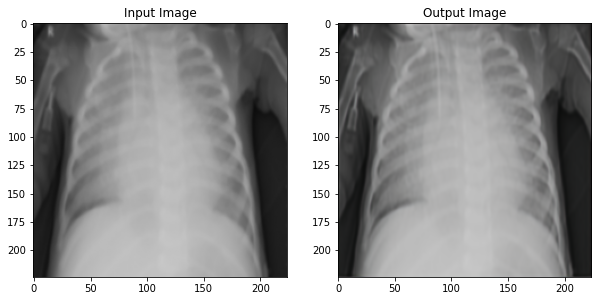

In [ ]:
# Load an example input image
img_path = '/content/drive/MyDrive/idb/dataset/Blur/person1004_bacteria_2935.jpeg'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
input_img = cv2.resize(img, (224, 224)) / 255.0


output_img = model1.predict(np.expand_dims(input_img, axis=0))[0]


fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(input_img)
ax[0].set_title('Input Image')
ax[1].imshow(output_img)
ax[1].set_title('Output Image')
plt.show()


1/1 [==============================] - 0s 23ms/step


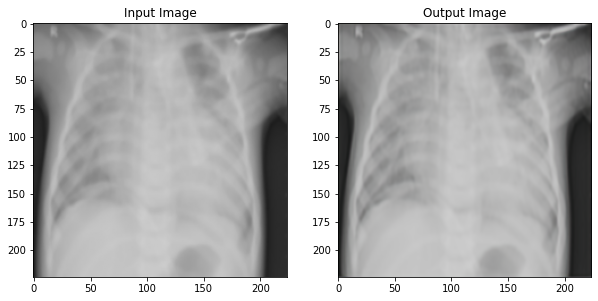

In [ ]:
# Load an example input image
img_path = '/content/drive/MyDrive/idb/dataset/Blur/person1007_bacteria_2938.jpeg'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
input_img = cv2.resize(img, (224, 224)) / 255.0


output_img = model1.predict(np.expand_dims(input_img, axis=0))[0]


fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(input_img)
ax[0].set_title('Input Image')
ax[1].imshow(output_img)
ax[1].set_title('Output Image')
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from keras.models import load_model

mo = load_model('/content/drive/MyDrive/idb/saved_model/Unet/unetkeras1.h5')


1/1 [==============================] - 0s 276ms/step


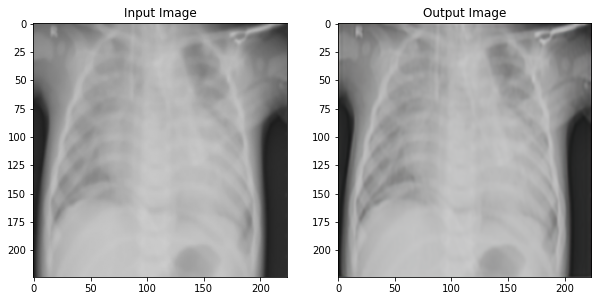

In [ ]:
# Load an example input image
img_path = '/content/drive/MyDrive/idb/dataset/Blur/person1007_bacteria_2938.jpeg'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
input_img = cv2.resize(img, (224, 224)) / 255.0


output_img = mo.predict(np.expand_dims(input_img, axis=0))[0]


fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(input_img)
ax[0].set_title('Input Image')
ax[1].imshow(output_img)
ax[1].set_title('Output Image')
plt.show()


One Last Try

In [ ]:
model2 = Model(inputs=inputs, outputs=conv10)
h=1
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_23 (Conv2D)             (None, 224, 224, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_24 (Conv2D)             (None, 224, 224, 64  36928       ['conv2d_23[0][0]']              
                                )                                                           

In [ ]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

def train(model, train_sharp, train_blur, val_sharp, val_blur, batch_size, epochs):
    opt = Adam(lr=1e-4)
    model.compile(loss='mse', optimizer=opt, metrics=['accuracy'])
    checkpoint = ModelCheckpoint('model2.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    callbacks_list = [checkpoint]
    model.fit(train_blur, train_sharp, batch_size=batch_size, epochs=epochs, validation_data=(val_blur, val_sharp), callbacks=callbacks_list)
    model.save("/content/drive/MyDrive/idb/saved_model/Unet/unetkeras2.h5")

def validate(model, val_sharp, val_blur):
    opt = Adam(lr=1e-4)
    model.compile(loss='mse', optimizer=opt, metrics=['accuracy'])
    model.load_weights('model2.h5')
    loss, acc = model1.evaluate(val_blur, val_sharp)
    print('Validation Loss:', loss)
    print('Validation Accuracy:', acc)

    pred_sharp = model.predict(val_blur)
    psnr = peak_signal_noise_ratio(val_sharp, pred_sharp)
    ssim = structural_similarity(val_sharp, pred_sharp, multichannel=True)
    print('PSNR:', psnr)
    print('SSIM:', ssim)
    return loss, acc
train(model1, train_sharp, train_blur, val_sharp, val_blur, batch_size=32, epochs=25)
validate(model1, val_sharp, val_blur)


Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 0.0162 - accuracy: 0.5329
Epoch 1: val_loss improved from inf to 0.00855, saving model to model2.h5
10/10 [==============================] - 49s 2s/step - loss: 0.0162 - accuracy: 0.5329 - val_loss: 0.0086 - val_accuracy: 0.1440
Epoch 2/25
10/10 [==============================] - ETA: 0s - loss: 0.0038 - accuracy: 0.4601
Epoch 2: val_loss improved from 0.00855 to 0.00118, saving model to model2.h5
10/10 [==============================] - 21s 2s/step - loss: 0.0038 - accuracy: 0.4601 - val_loss: 0.0012 - val_accuracy: 0.7063
Epoch 3/25
10/10 [==============================] - ETA: 0s - loss: 0.0012 - accuracy: 0.4891
Epoch 3: val_loss improved from 0.00118 to 0.00110, saving model to model2.h5
10/10 [==============================] - 21s 2s/step - loss: 0.0012 - accuracy: 0.4891 - val_loss: 0.0011 - val_accuracy: 0.2272
Epoch 4/25
10/10 [==============================] - ETA: 0s - loss: 9.4188e-04 - accuracy: 0.4844
Epo

3/3 [==============================] - 2s 320ms/step - loss: 4.7282e-04 - accuracy: 0.4090
Validation Loss: 0.0004728207422886044
Validation Accuracy: 0.40897366404533386
3/3 [==============================] - 1s 403ms/step


<ipython-input-41-0ef8f1d4ddca>:20: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(val_sharp, pred_sharp)
<ipython-input-41-0ef8f1d4ddca>:21: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim = structural_similarity(val_sharp, pred_sharp, multichannel=True)
/usr/local/lib/python3.9/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


PSNR: 33.25303496551163
SSIM: 0.9889934135296435


(0.0004728207422886044, 0.40897366404533386)

In [ ]:
mod = load_model('model2.h5')

NameError: ignored

1/1 [==============================] - 0s 233ms/step


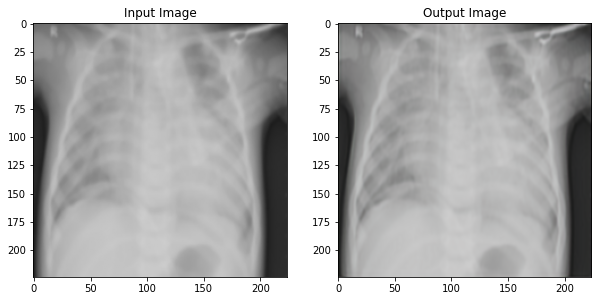

In [ ]:
# Load an example input image
img_path = '/content/drive/MyDrive/idb/dataset/Blur/person1007_bacteria_2938.jpeg'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
input_img = cv2.resize(img, (224, 224)) / 255.0


output_img = mod.predict(np.expand_dims(input_img, axis=0))[0]


fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(input_img)
ax[0].set_title('Input Image')
ax[1].imshow(output_img)
ax[1].set_title('Output Image')
plt.show()
